# Color transfer between images

**Louis Martinez**

[Link to the paper](./Articles/Color_Transfer.pdf)  

This notebook aims to explore, as an introduction for future work, the properties of the Monge-Kantorovitch theory (Optimal Transport) through the example of color transfer. It's an implementation of a [Numerical Tours article](http://www.numerical-tours.com/matlab/optimaltransp_4_matching_sliced/) by Gabriel Peyré.


Formaly speaking, we aim to find the optimal transportation cost to transport a distiburion $f$ on a distibution $g$ :

$$MK_c(f,g)=\underset{\pi\in\Pi(f,g)}{inf}\iint_{x,y}c(x,y)d\pi(x,y)$$

The distance defined above is also called **Wasserstein** distance

In [1]:
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from scipy.stats import wasserstein_distance
from tqdm import tqdm

np.random .seed(0)

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

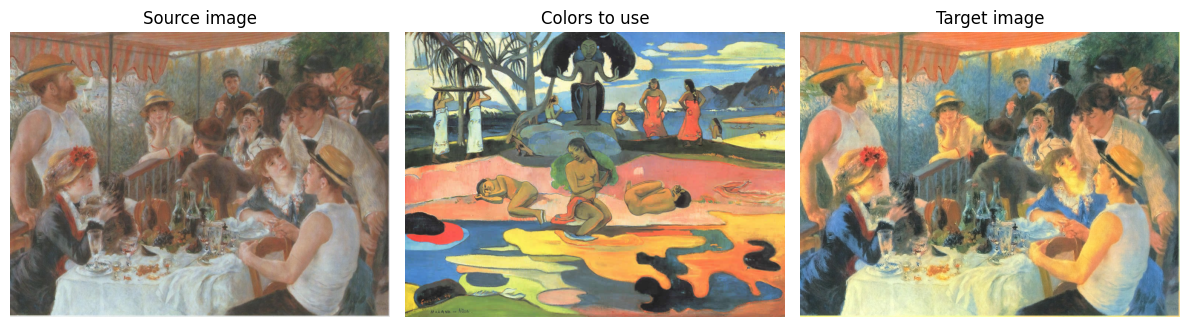

In [2]:
im_src = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/color_transfer/renoir.jpg')
im_color = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/color_transfer/gauguin.jpg')
im_target = imread('https://raw.githubusercontent.com/lmartinez2001/Resources/main/color_transfer/renoir_by_gauguin.jpg')

fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].imshow(im_src)
ax[0].set_title('Source image')
ax[0].axis('off')
ax[1].imshow(im_color)
ax[1].set_title('Colors to use')
ax[1].axis('off')
ax[2].imshow(im_target)
ax[2].set_title('Target image')
ax[2].axis('off')
plt.tight_layout()
plt.show()

---
## Wasserstein distance and projection

To get more familiar with optimal transport theory, let's illustrate the key concepts on a toy 2D example.

We consider data (here images) as $f\in\mathbb{R}^{N\times d}$ where $N$ is the number of pixels and $d$ the number of channels (1 for grayscale image, 3 for RGB images).  
$f=(f_i)_{i=1}^N$

### Definition of Wasserstein Distance

We define the distribution in $\mathbb{R}^d$ associated to $f$ (i.e. the histogram of each channel of the image):
$$\mu_f=\frac{1}{N}\sum_{i=1}^N \delta_{f_i}$$
We want to find the permutation $\sigma\in\Sigma_N$ the following sum:
$$\sigma^*\in \underset{\sigma\in\Sigma_N}{argmin} \sum_{i=1}^N\|f_i-g_{\sigma(i)}\|^2$$

$\sigma^*$ is called the optimal assignment and defines the Wasserstein distance:
$$W_2(\mu_f,\mu_g)^2=\sum_{i=1}^N\|f_i-g_{\sigma^*(i)}\|^2=\|f-g\circ\sigma^*\|_2^2$$

In practice, we re-order the $g$ point cloud to match $f$ distribution the best

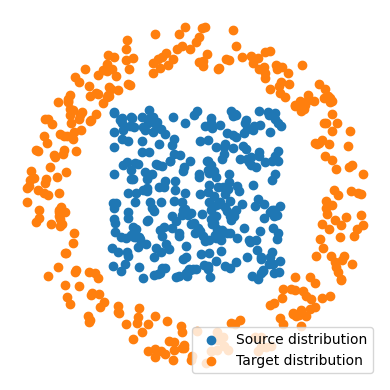

In [3]:
N = 300
d = 2

def normalized_hist(I):
    """
    Computes the normalized histogram of a given image
    """
    N = float(I.shape[0] * I.shape[1])
    hist, edge = np.histogram(I, bins=256, range=[0,256])
    hist = hist.astype(np.float32)/N
    return hist, edge

# define first distribution as 2D points uniformely sampled on a square
dist_1 = np.array([uniform(-1, 1, N), uniform(-1, 1, N)])

# define second distribution sample on a circle
theta = uniform(0, 2 * np.pi, N)
radius = uniform(1.5, 2, N)
dist_2 = radius * np.array([np.cos(theta), np.sin(theta)])

plt.figure(figsize=(4,4))
plt.scatter(dist_1[0], dist_1[1], label='Source distribution')
plt.scatter(dist_2[0], dist_2[1], label='Target distribution')
plt.axis('off')
plt.legend()
plt.tight_layout()
plt.show()

---
## Sliced Wasserstein distance and projection

According to the source, it is computationaly expensive to compute such a distance with data of higher dimensions ($O(N^3)$ with Hungarian algorithm).  
Hence Sliced Wasserstein distance was introduced. It is obtained by computing 1D Wasserstein distances of projected point clouds:
$$SW_2(\mu_f,\mu_g) = \int_{\mathbb{S}^{d-1}}W_2(\mu_{f_\theta}, \mu_{g_\theta})^2d\theta$$ 
where:
$$\mathbb{S}^{d-1}=\{\theta\in\mathbb{R}^d:\|\theta\|=1\}$$
and:
$$\mu_{f_\theta}=(\langle f_i, \theta\rangle)_{i=1}^N\in\mathbb{R}^N$$

To compute this quantity, we must approximate this integral. There are two ways for that:
1. Choosing a set of random vectors of $\mathbb{S}^{d-1}$ and computing the projections onto this vectors
2. Projecting points clouds on an orthogonal basis of $\mathbb{S}^{d-1}$

The second option is the cheapest in terms and computation cost and results are convicing, as discussed below. Hence this is the method implemented here.  
To compute the orthogonal basis we use the Gram-Schmidt algorithm.

In [4]:
def compute_ortho_basis(d):
    """
    Computes an orthogonal basis or R^d using Gram Schmidt algorithm
    """
    v = np.random.randn(d, d)
    # Gram Schmidt algorithm
    u = np.zeros_like(v)
    u[0] = v[0]
    for i in range(1, d):
        u[i] = v[i]
        for j in range(i):
            u[i] -= (np.dot(v[i],u[j]) / np.dot(u[j], u[j])) * u[j]
    u /= np.linalg.norm(u, axis=1, keepdims=True)
    return u

def optimal_assignment_1D(f, g):
    """
    Determines the optimal 1D assignment (permutation) as defined above
    """
    sigma_f = f.argsort()
    sigma_f_inverse = sigma_f.argsort()
    sigma_g = g.argsort()
    sigma_star = sigma_g[sigma_f_inverse]
    return sigma_star

def P(f, g):
    """
    Computes the orthogonal projection of f on the set \Pi_g(f) as defined above
    """
    sigma_star = optimal_assignment_1D(f, g)
    return g[sigma_star]

def W2(f, g):
    """
    Computes 1D wasserstein distance between distributions f and g
    """
    assert f.shape == g.shape
    return np.linalg.norm(f - P(f,g))

def SW2(f, g):
    """
    Computes the d-dimension sliced wasserstein distance between f and g
    """
    d = f.shape[0]
    thetas = compute_ortho_basis(d) # (d, d)
    dist = 0
    for theta in thetas:
        f_theta = np.dot(theta, f)
        g_theta = np.dot(theta, g)
        dist += W2(f_theta, g_theta)
    return dist

def f_tilde(f, g, thetas):
    """
    f and g of shape (d, N)
    """
    f_theta_star = thetas.T @ f
    g_theta_star = thetas.T @ g
    
    projections = []
    for i in range(len(f)):
        projections.append(P(f_theta_star[i],g_theta_star[i]))
    return thetas @ projections                                                    

### Testing Gram-Schmidt algorithm

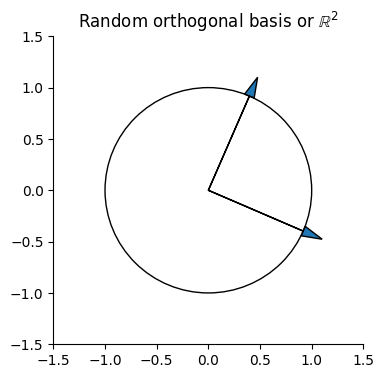

In [5]:
ortho_basis = compute_ortho_basis(2)
plt.figure(figsize=(4,4))
for i in range(len(ortho_basis)):
    plt.arrow(0, 0, ortho_basis[i,0], ortho_basis[i,1], head_width=0.1, head_length=0.2)
circle = plt.Circle((0,0), 1, fill=False)
ax = plt.gca()
ax.add_patch(circle)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5,1.5)
plt.title(r'Random orthogonal basis or $\mathbb{R}^{2}$')
plt.show()

---
## Example on toy dataset

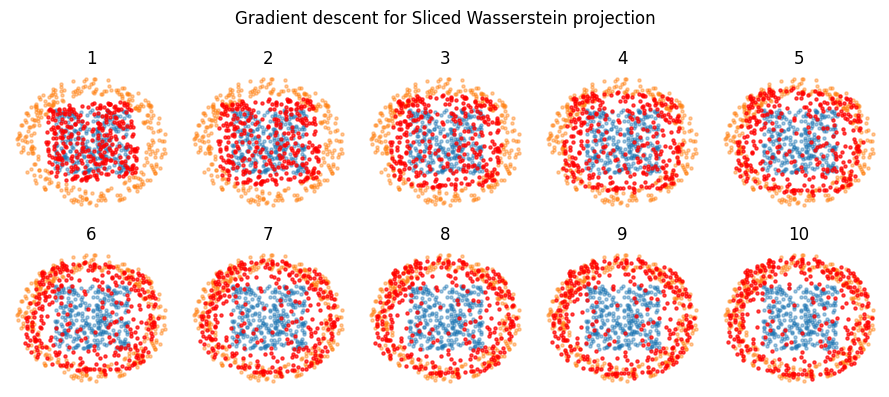

In [ ]:
tau = .2
d=2
f = dist_1
g = dist_2


n_iter = 10
f1 = f

fig, axes = plt.subplots(2, 5, figsize=(9,4))
ax = axes.ravel()
plt.suptitle('Gradient descent for Sliced Wasserstein projection')
for i in range(n_iter) :
    thetas = compute_ortho_basis(d)
    f1 = (1-tau)*f1 + tau * f_tilde(f1,g,thetas)
    ax[i].scatter(f[0], f[1], alpha=.4, s=5)
    ax[i].scatter(g[0], g[1], alpha=.4, s=5)
    ax[i].scatter(f1[0],f1[1], c='r', alpha=.7, s=5)
    ax[i].axis('off')
    ax[i].set_title(f'{i+1}')
plt.tight_layout()
plt.show()

---
## Applying sliced Wasserstein projection on images

In [7]:
r, c, d = im_src.shape
f = im_src.transpose(2,0,1).reshape(d,-1)
g = im_color.transpose(2,0,1).reshape(d,-1)

n_iter = 500
f1 = f
tau = .3
for i in tqdm(range(n_iter)) :
    thetas = compute_ortho_basis(d)
    f1 = (1-tau)*f1 + tau * f_tilde(f1,g,thetas)

im_res =  f1.reshape(d,r,c).transpose(1,2,0)
im_res = (im_res - im_res.min()) / (im_res.max()-im_res.min())

100%|██████████| 500/500 [04:12<00:00,  1.98it/s]


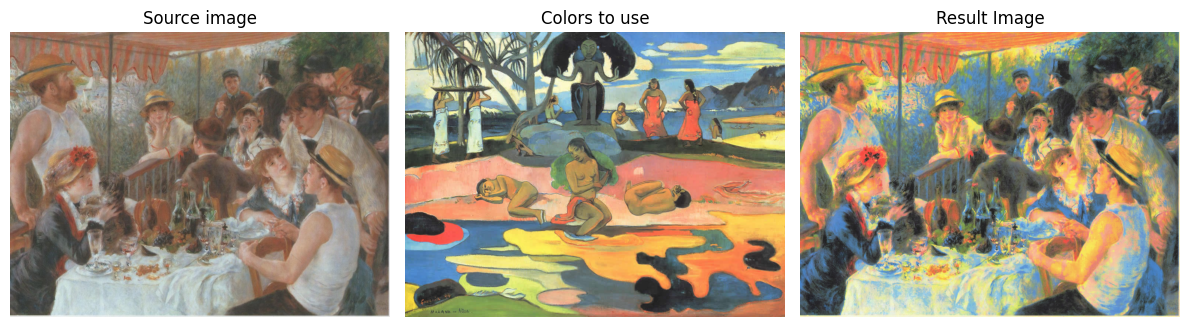

In [20]:
fig, ax = plt.subplots(1,3,figsize=(12,5))
ax[0].imshow(im_src)
ax[0].set_title('Source image')
ax[0].axis('off')
ax[1].imshow(im_color)
ax[1].set_title('Colors to use')
ax[1].axis('off')
ax[2].imshow(im_res)
ax[2].set_title('Result Image')
ax[2].axis('off')
plt.tight_layout()
plt.show()